In [3]:
# 1. 导入依赖
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# 让图像内嵌在 notebook 里显示
%matplotlib inline

In [4]:
# 2. 读取月度特征数据
monthly_path = "data/sh000016_monthly_features.csv"  # 如果路径不同，在这里改
df_month = pd.read_csv(monthly_path)

# 简单看一下列名和前几行
print(df_month.columns)
df_month.head()


Index(['month', 'close_month_end', 'ret_month', 'vol_month_sum',
       'vol_month_chg', 'vol_20_annual_month_end', 'vol_60_annual_month_end',
       'month_str'],
      dtype='object')


,month,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str
0,2015-01-31,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01
1,2015-02-28,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02
2,2015-03-31,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03
3,2015-04-30,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04
4,2015-05-31,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05


In [6]:
# 3. 处理日期列并设为索引
date_col = "month"   # 如果你的列叫 'month' 就改成 "month"
df_month[date_col] = pd.to_datetime(df_month[date_col])
df_month = df_month.sort_values(date_col).set_index(date_col)

df_month.head()


,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str
month,,,,,,,
2015-01-31,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01
2015-02-28,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02
2015-03-31,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03
2015-04-30,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04
2015-05-31,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05


In [11]:
# 3. 指定用于 Regime 聚类的特征列
feature_cols = [
    "ret_month",
    "vol_month_sum",
    "vol_20_annual_month_end"
]

# 检查列是否存在
missing = [c for c in feature_cols if c not in df_month.columns]
if missing:
    print("缺失列：", missing)
else:
    print("聚类特征列：", feature_cols)

# 4. 取出特征矩阵并标准化
X_raw = df_month[feature_cols].copy().dropna()
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

X.shape


聚类特征列： ['ret_month', 'vol_month_sum', 'vol_20_annual_month_end']


(120, 3)

/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36873 (\N{CJK UNIFIED IDEOGRAPH-9009}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25321 (\N{CJK U

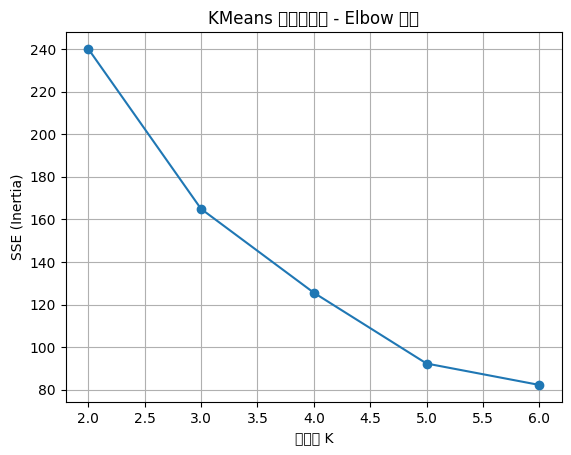

In [12]:
# 5. Elbow 曲线 (SSE)
sse = []
K_range = range(2, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    sse.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), sse, marker="o")
plt.xlabel("聚类数 K")
plt.ylabel("SSE (Inertia)")
plt.title("KMeans 聚类数选择 - Elbow 曲线")
plt.grid(True)
plt.show()


/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24275 (\N{CJK UNIFIED IDEOGRAPH-5ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/test1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19981 (\N{CJK U

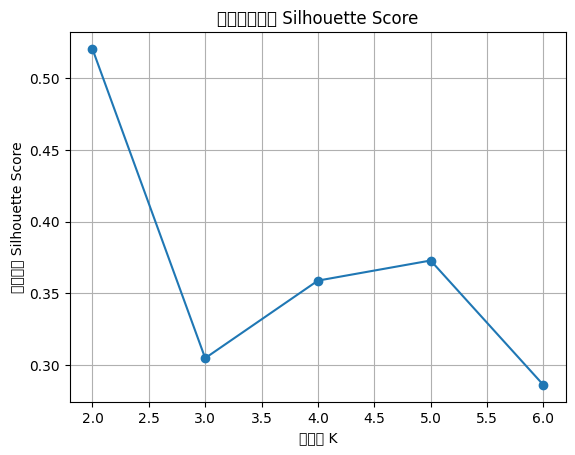

[(2, np.float64(0.5203540742408097)),
 (3, np.float64(0.304812888705872)),
 (4, np.float64(0.3588605817272719)),
 (5, np.float64(0.3728757902352798)),
 (6, np.float64(0.2861553907304862))]

In [13]:
# 6. Silhouette Score
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure()
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("聚类数 K")
plt.ylabel("轮廓系数 Silhouette Score")
plt.title("不同聚类数的 Silhouette Score")
plt.grid(True)
plt.show()

list(zip(K_range, sil_scores))


In [14]:
# 7. KMeans 聚类
K = 3  # 如果你觉得 4 更好，就改成 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X)

df_cluster = df_month.loc[X_raw.index].copy()
df_cluster["cluster"] = cluster_labels

df_cluster.head()


,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str,cluster
month,,,,,,,,
2015-01-31,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01,2
2015-02-28,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02,0
2015-03-31,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03,2
2015-04-30,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04,2
2015-05-31,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05,2


In [15]:
# 8. 不同 cluster 的特征均值（很重要）
cluster_profile = df_cluster.groupby("cluster")[feature_cols].mean()
cluster_profile


,ret_month,vol_month_sum,vol_20_annual_month_end
cluster,,,
0,0.052686,7.565731e+10,0.175145
1,-0.030444,6.459630e+10,0.178653
2,-0.019967,2.975105e+11,0.453852


In [16]:
# 9. 根据 cluster_profile 的结果手动映射 Regime 名称
cluster_to_regime = {
    0: "Regime_Bull",      # 比如 0 类：上涨+低波动
    1: "Regime_Bear",      # 比如 1 类：下跌+高波动
    2: "Regime_Sideways",  # 比如 2 类：震荡
}

df_cluster["regime"] = df_cluster["cluster"].map(cluster_to_regime)

df_cluster[["cluster", "regime"]].head()


,cluster,regime
month,,
2015-01-31,2,Regime_Sideways
2015-02-28,0,Regime_Bull
2015-03-31,2,Regime_Sideways
2015-04-30,2,Regime_Sideways
2015-05-31,2,Regime_Sideways


/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84j

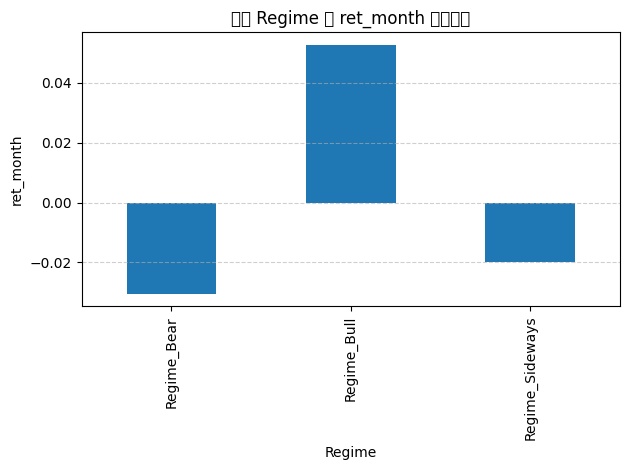

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84j

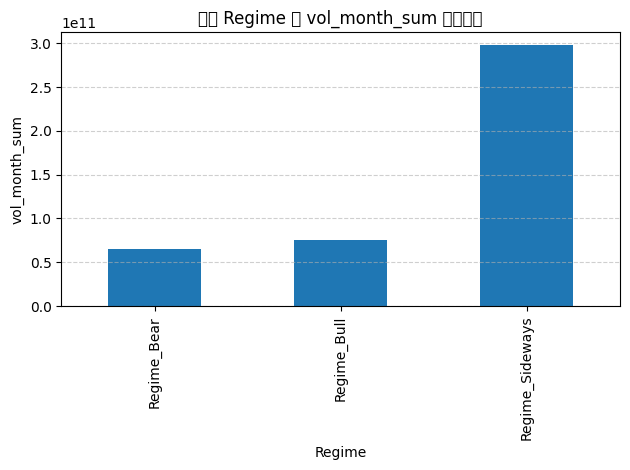

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2730413094.py:11: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84j

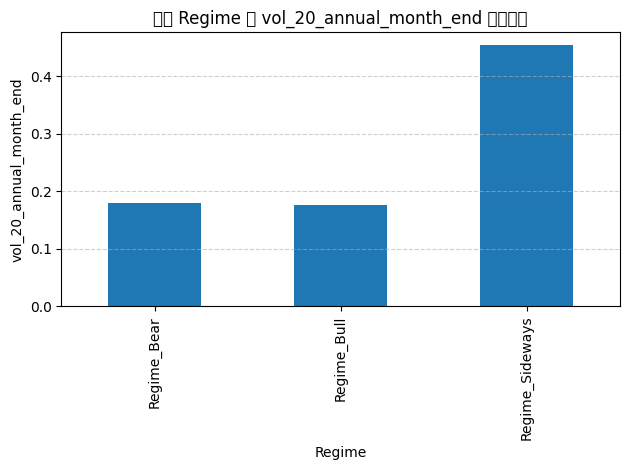

In [17]:
# 10. Regime 画像（每个特征一个柱状图）
regime_profile = df_cluster.groupby("regime")[feature_cols].mean()

for col in feature_cols:
    plt.figure()
    regime_profile[col].plot(kind="bar")
    plt.title(f"不同 Regime 下 {col} 的平均值")
    plt.xlabel("Regime")
    plt.ylabel(col)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2043371869.py:13: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2043371869.py:13: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2043371869.py:13: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2043371869.py:13: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_96098/2043371869.py:13: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/49/t84j

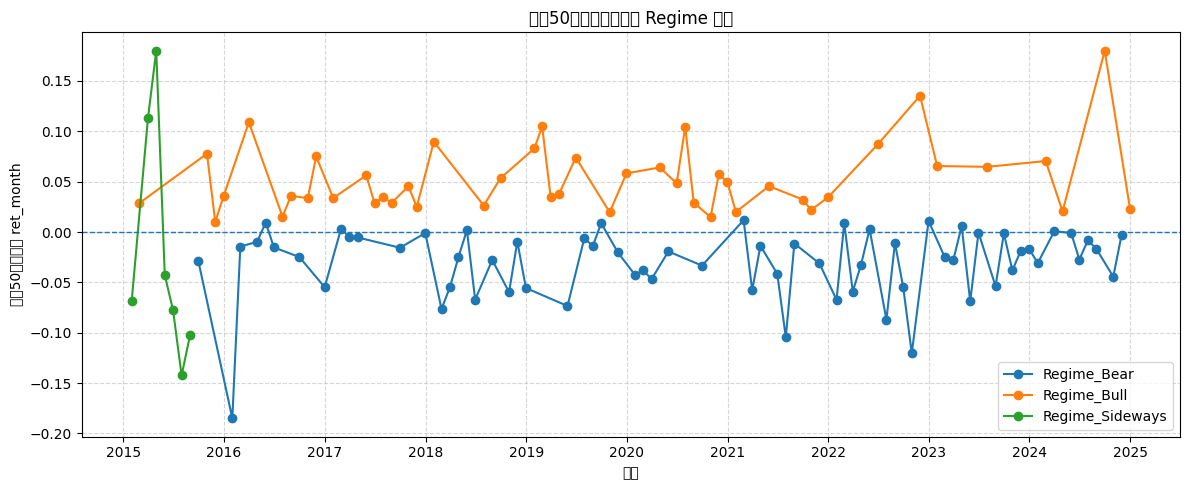

In [18]:
# 11. 在时间轴上按 Regime 着色显示月度收益
plt.figure(figsize=(12, 5))

for regime_name, sub_df in df_cluster.groupby("regime"):
    plt.plot(sub_df.index, sub_df["ret_month"], marker="o", linestyle="-", label=regime_name)

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("时间")
plt.ylabel("上证50月度收益 ret_month")
plt.title("上证50月度收益及市场 Regime 划分")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


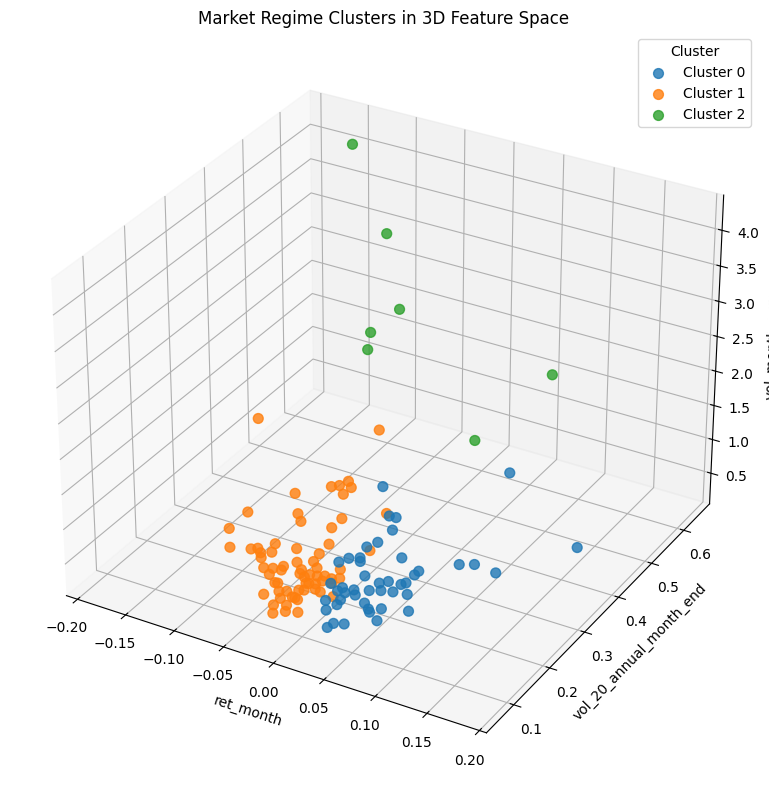

In [19]:
from mpl_toolkits.mplot3d import Axes3D  # 仅为激活 3D 支持
import matplotlib.pyplot as plt

# 选择要画的三个维度
x_col = "ret_month"
y_col = "vol_20_annual_month_end"
z_col = "vol_month_sum"

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for c, sub in df_cluster.groupby("cluster"):
    ax.scatter(
        sub[x_col],
        sub[y_col],
        sub[z_col],
        s=50,
        label=f"Cluster {c}",
        alpha=0.8,
    )

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("Market Regime Clusters in 3D Feature Space")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


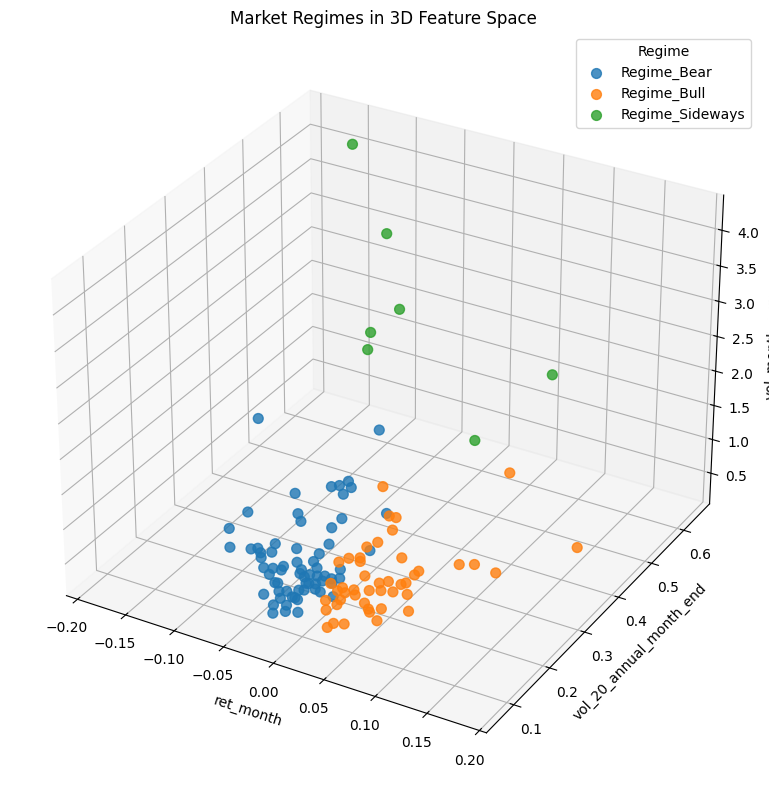

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for r, sub in df_cluster.groupby("regime"):
    ax.scatter(
        sub[x_col],
        sub[y_col],
        sub[z_col],
        s=50,
        label=r,
        alpha=0.8,
    )

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("Market Regimes in 3D Feature Space")
ax.legend(title="Regime")
plt.tight_layout()
plt.show()
